# **Batch Normalization to Layer Normalization & Bidirectional LSTM**

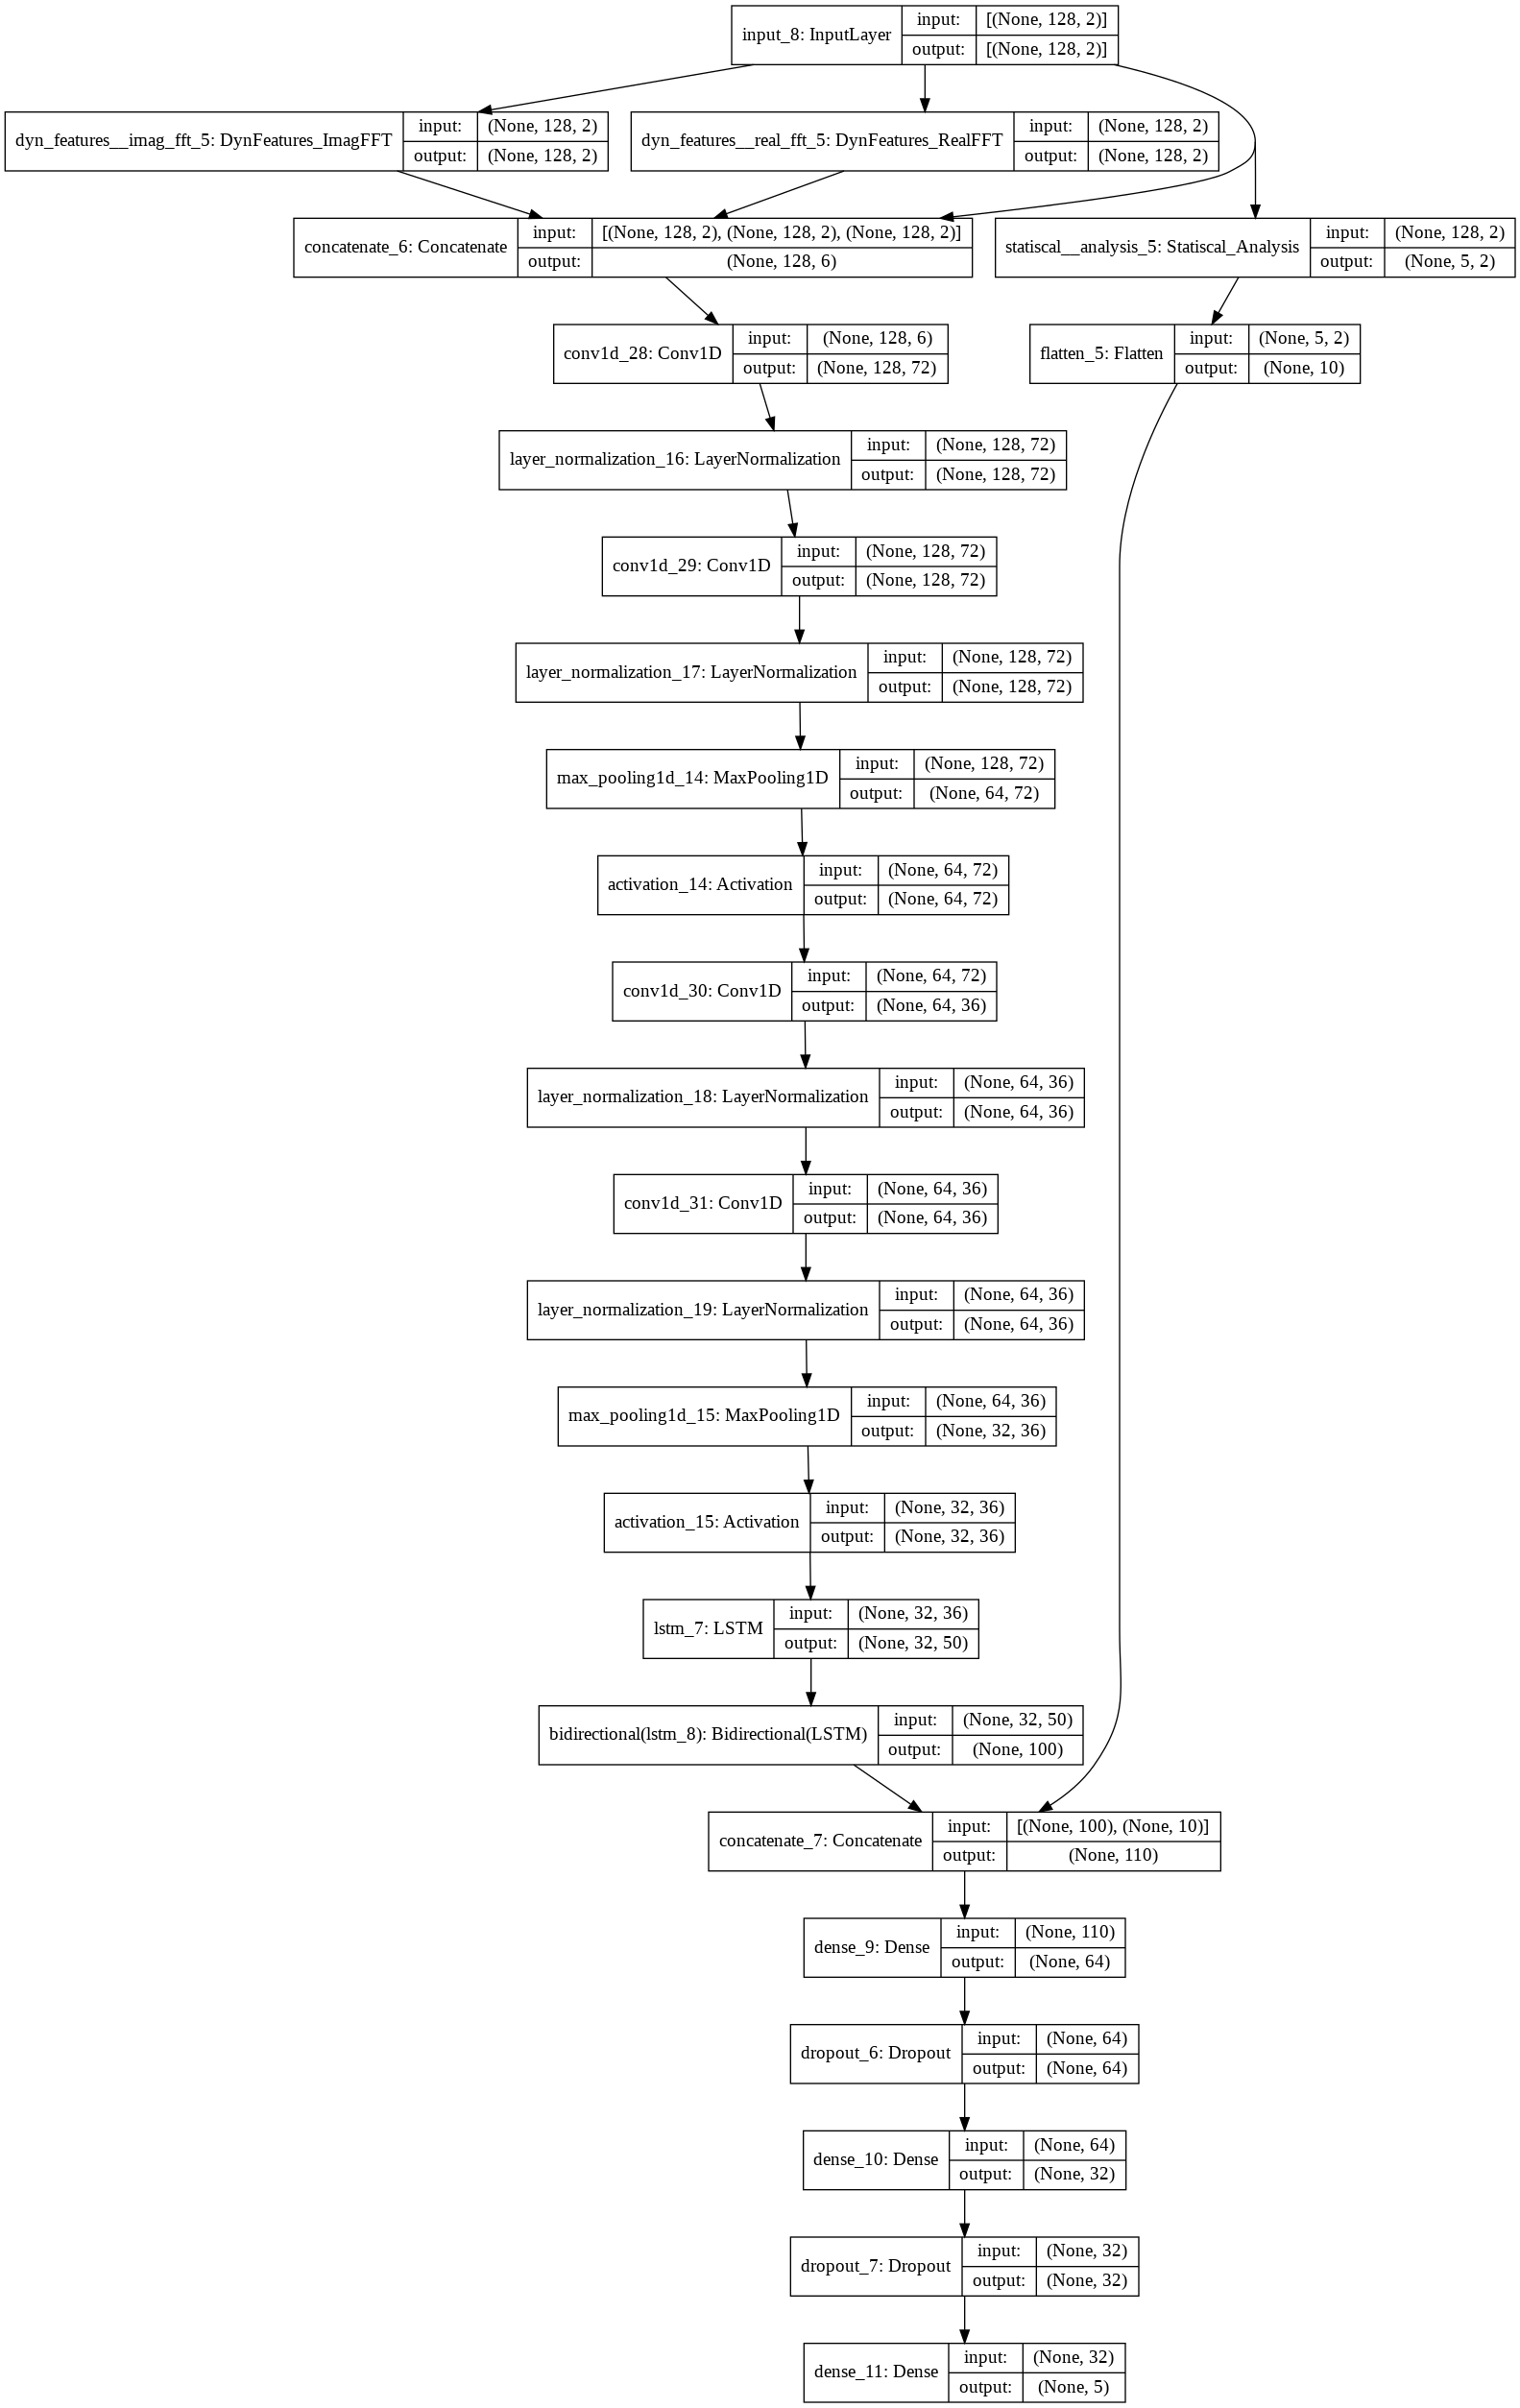

In [30]:
def Convolutional_LSTM_WITHOUT_CWT_Layer(kernel = 72, CWT_Freq = 4, kernel_size= 10):
  inputs = keras.Input(shape = (128,2))
  i = DynFeatures_ImagFFT()(inputs)
  r = DynFeatures_RealFFT()(inputs)
  Dynamic_Features = keras.layers.Concatenate()([i,r,inputs])
  Statistical_Features = Statiscal_Analysis(length_of_signal=128)(inputs)
  Statistical_Features = keras.layers.Flatten()(Statistical_Features)
  x = keras.layers.Conv1D(kernel, kernel_size, padding = 'same')(Dynamic_Features)
  x = keras.layers.LayerNormalization()(x)
  x = keras.layers.Conv1D(kernel, kernel_size, padding = 'same')(x)
  x = keras.layers.LayerNormalization()(x)
  x = keras.layers.MaxPool1D(pool_size = 2)(x)
  x = keras.layers.Activation('elu')(x)
  x = keras.layers.Conv1D(kernel/2, kernel_size, padding = 'same')(x)
  x = keras.layers.LayerNormalization()(x)
  x = keras.layers.Conv1D(kernel/2, kernel_size, padding = 'same')(x)
  x = keras.layers.LayerNormalization()(x)
  x = keras.layers.MaxPool1D(pool_size = 2)(x)
  x = keras.layers.Activation('elu')(x)
  x = keras.layers. LSTM(50, return_sequences = True)(x)
  x = keras.layers.Bidirectional(LSTM(50))(x)
  x = keras.layers.Concatenate()([x, Statistical_Features])
  x = keras.layers.Dense(units = 64, activation = 'elu', kernel_initializer = 'he_normal')(x)
  x = keras.layers.Dropout(0.5)(x)
  x = keras.layers.Dense(units = 32, activation = 'elu', kernel_initializer = 'he_normal')(x)
  x = keras.layers.Dropout(0.5)(x)
  outputs = keras.layers.Dense(units = 5, activation = 'softmax')(x)
  model = keras.Model(inputs, outputs)
  return model
CLSTM_WITHOUT_CWT_LAYER = Convolutional_LSTM_WITHOUT_CWT_Layer()
keras.utils.plot_model(CLSTM_WITHOUT_CWT_LAYER, show_shapes=True)

In [ ]:
CLSTM_WITHOUT_CWT_LAYER.summary()
CLSTM_WITHOUT_CWT_LAYER.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

hist2 = CLSTM_WITHOUT_CWT_LAYER.fit(Train_Dataset, epochs = 10, shuffle = True, validation_data = Valid_Dataset,
                      callbacks = callbacks)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 128, 2)]     0                                            
__________________________________________________________________________________________________
dyn_features__imag_fft_5 (DynFe (None, 128, 2)       0           input_8[0][0]                    
__________________________________________________________________________________________________
dyn_features__real_fft_5 (DynFe (None, 128, 2)       0           input_8[0][0]                    
__________________________________________________________________________________________________
concatenate_6 (Concatenate)     (None, 128, 6)       0           dyn_features__imag_fft_5[0][0]   
                                                                 dyn_features__real_fft_5[0]

# EDA AND PREPROCESSING

In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import warnings
from tqdm import tqdm
warnings.filterwarnings( 'ignore' )

import matplotlib.pyplot as plt
import os 
import sys
import time
import seaborn as sns
import math

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AX4XfWj0LjS5uzX_dTc0y-azBP15yNVSgNg-8S_BrcnX2w6gh20htiUpw0A
Mounted at /content/drive


In [4]:
path = '/content/drive/MyDrive/phm'
file_list = os.listdir(path)
print(file_list)

['train_1st_Bearing.csv', 'train_1st_high.csv', 'train_1st_Looseness.csv', 'train_1st_Unbalance.csv', 'train_1st_Normal.csv', 'train_2nd_Unbalance.csv', 'train_3rd_Unbalance.csv', 'train_3rd_Normal.csv', 'train_2nd_Looseness.csv', 'train_2nd_Bearing.csv']


In [5]:
def Dataset_Constructor(df, time_series_length = 128, NumofChannel = 2, label = None, window = 128):

  #Normal[label 0] → Fault-free operating condition
  #Unbalance[label 1] → Unbalance between centers of mass and axis
  #Belt-Looseness[label 2] → Looseness of V‐belt connecting between motor pully and screw pully
  #Belt-Looseness High[label 3] → High Looseness of V-belt
  #Bearing fault[label 4] → Removing grease of Ball Bearing on Motor, which induces its wear-out

  Number_of_data = int(df.shape[0]/(time_series_length -( 128 - window )))-130
  data_array = np.zeros((Number_of_data, time_series_length, NumofChannel))
  label = np.full_like(np.zeros((Number_of_data)), label)
  for i in tqdm(range(Number_of_data)):
    data_array[i]= df.iloc[window*(i) : window*i+128,: ].values
  ds = tf.data.Dataset.from_tensor_slices((data_array ,label))
  return ds

def Dataset_Constructor2(df, time_series_length = 128, NumofChannel = 2, label = None, window = 128):

  #Normal[label 0] → Fault-free operating condition
  #Unbalance[label 1] → Unbalance between centers of mass and axis
  #Belt-Looseness[label 2] → Looseness of V‐belt connecting between motor pully and screw pully
  #Belt-Looseness High[label 3] → High Looseness of V-belt
  #Bearing fault[label 4] → Removing grease of Ball Bearing on Motor, which induces its wear-out

  Number_of_data = int(df.shape[0]/(time_series_length -( 128 - window )))
  data_array = np.zeros((Number_of_data, time_series_length, NumofChannel))
  label = np.full_like(np.zeros((Number_of_data)), label)
  for i in tqdm(range(Number_of_data)):
    data_array[i]= df.iloc[window*(i) : window*i+128,: ].values
  ds = tf.data.Dataset.from_tensor_slices((data_array ,label))
  
  return ds

def TEST_Dataset_Constructor(df, time_series_length = 128, NumofChannel = 2, label = None, window = 128):
  Number_of_data = int(df.shape[0]/(time_series_length -( 128 - window )))
  data_array = np.zeros((Number_of_data, time_series_length, NumofChannel))
  label = np.full_like(np.zeros((Number_of_data)), label)
  for i in tqdm(range(Number_of_data)):
    data_array[i]= df.iloc[window*(i) : window*i+128,: ].values
  ds = tf.data.Dataset.from_tensor_slices((data_array ,label))

### DATA Loading

In [6]:
sub = pd.read_csv('/content/drive/MyDrive/phm_Result/sample_submission_classification (3).csv')
final = pd.read_csv('/content/drive/MyDrive/phm_Result/final.csv').iloc[:,1:]
test_Dataset = Dataset_Constructor2(final)

100%|██████████| 12592/12592 [00:00<00:00, 15558.14it/s]


In [7]:
test_Dataset = Dataset_Constructor2(final).batch(128).prefetch(1)

100%|██████████| 12592/12592 [00:00<00:00, 18552.23it/s]


In [8]:
train_1st_Bearing = pd.read_csv(os.path.join(path, file_list[0]),float_precision = 'round_trip').iloc[:, 1:]
train_1st_Looseness = pd.read_csv(os.path.join(path, file_list[1]),float_precision = 'round_trip').iloc[:, 1:]
train_1st_Normal = pd.read_csv(os.path.join(path, file_list[2]),float_precision = 'round_trip').iloc[:, 1:]
train_1st_Unbalance = pd.read_csv(os.path.join(path, file_list[3]),float_precision = 'round_trip').iloc[:, 1:]
train_1st_high = pd.read_csv(os.path.join(path, file_list[4]),float_precision = 'round_trip').iloc[:, 1:]
train_2nd_Bearing = pd.read_csv(os.path.join(path, file_list[5]),float_precision = 'round_trip').iloc[:, 1:]
train_2nd_Looseness = pd.read_csv(os.path.join(path, file_list[6]),float_precision = 'round_trip').iloc[:, 1:]
train_2nd_Unbalance = pd.read_csv(os.path.join(path, file_list[7]),float_precision = 'round_trip').iloc[:, 1:]
train_3rd_Normal = pd.read_csv(os.path.join(path, file_list[8]),float_precision = 'round_trip').iloc[:, 1:]
train_3rd_Unbalance = pd.read_csv(os.path.join(path, file_list[9]),float_precision = 'round_trip').iloc[:, 1:]

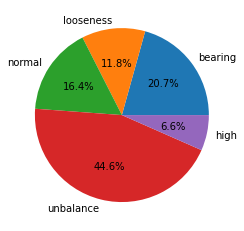

In [9]:
bearing = train_1st_Bearing.shape[0]+train_2nd_Bearing.shape[0]
looseness = train_1st_Looseness.shape[0]+train_2nd_Looseness.shape[0]
normal = train_1st_Normal.shape[0] + train_3rd_Normal.shape[0]
unbalance = train_1st_Unbalance.shape[0] + train_2nd_Unbalance.shape[0] + train_3rd_Unbalance.shape[0]
high = train_1st_high.shape[0] 

plt.pie([bearing,looseness,normal,unbalance,high], labels=['bearing','looseness','normal','unbalance','high'], autopct='%.1f%%')
plt.show()

### Dataset Construction/Augmentation and Solving Class Imabalance Problem

In [10]:
Bearing1st_ds = Dataset_Constructor(train_1st_Bearing, label = 4 )
Looseness1st_ds = Dataset_Constructor(train_1st_Looseness,label = 2,window = 80)
Normal1st_ds = Dataset_Constructor(train_1st_Normal, label = 0 )
Unbalance1st_ds = Dataset_Constructor(train_1st_Unbalance, label = 1)
High1st_ds = Dataset_Constructor(train_1st_high, label = 3, window = 9)

100%|██████████| 1739630/1739630 [01:41<00:00, 17062.53it/s]


In [11]:
Bearing2nd_ds = Dataset_Constructor(train_2nd_Bearing, label = 4 )
Looseness2nd_ds = Dataset_Constructor(train_2nd_Looseness,label = 2,window = 80)
Unbalance2nd_ds = Dataset_Constructor(train_2nd_Unbalance, label = 1)
Normal3rd_ds = Dataset_Constructor(train_3rd_Normal, label = 0)
Unbalance3rd_ds = Dataset_Constructor(train_3rd_Unbalance, label = 1)

100%|██████████| 320341/320341 [00:18<00:00, 17411.64it/s]


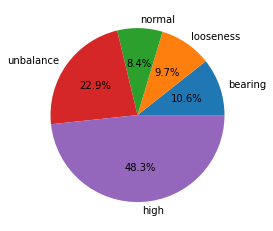

In [12]:
bearing = Bearing1st_ds.__len__().numpy() + Bearing2nd_ds.__len__().numpy()
looseness = Looseness1st_ds.__len__().numpy() + Looseness2nd_ds.__len__().numpy()
normal = Normal1st_ds.__len__().numpy() + Normal3rd_ds.__len__().numpy()
unbalance = Unbalance1st_ds.__len__().numpy() + Unbalance2nd_ds.__len__().numpy() + Unbalance3rd_ds.__len__().numpy()
high = High1st_ds.__len__().numpy()

plt.pie([bearing,looseness,normal,unbalance,high], labels=['bearing','looseness','normal','unbalance','high'], autopct='%.1f%%')
plt.show()

In [13]:
batch_size = 128
Dataset = Bearing1st_ds.concatenate(Looseness1st_ds).concatenate(Normal1st_ds).concatenate(Unbalance1st_ds).concatenate(High1st_ds).concatenate(Bearing2nd_ds).concatenate(Looseness2nd_ds).concatenate(Unbalance2nd_ds).concatenate(Normal3rd_ds).concatenate(Unbalance3rd_ds).shuffle(buffer_size = 4518720, seed = 42).batch(batch_size).prefetch(1)

In [14]:
Dataset.__len__().numpy()

28130

In [15]:
Valid_Dataset = Dataset.take(15 * batch_size) 
Train_Dataset = Dataset.skip(15 * batch_size)
Train_Dataset = Dataset.take(135 * batch_size)

# VISUALIZATION

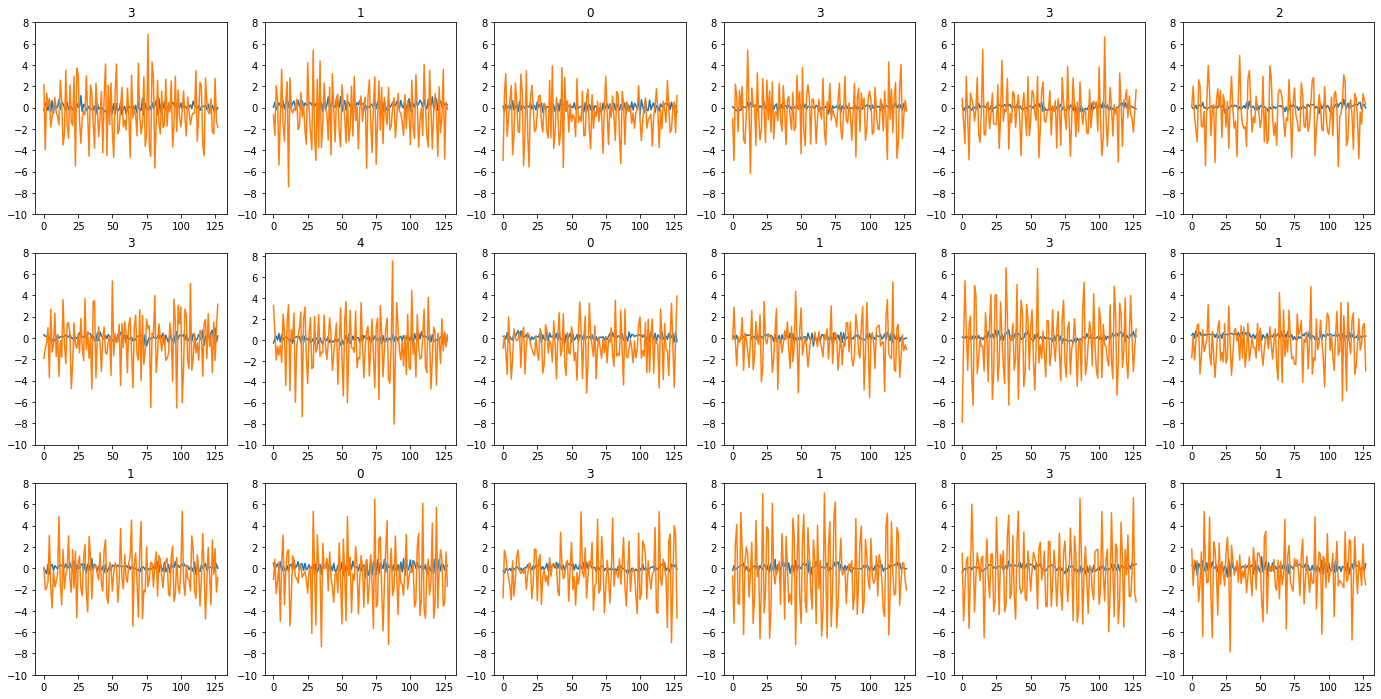

In [ ]:
rows = 3
cols = 6
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(24, 12))
for i, (audio, label) in enumerate(Dataset.unbatch().take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-10, 10, 2))
  label = int(label.numpy())#.decode('utf-8')
  ax.set_title(label)

# CUSTOM LAYER

In [16]:
class DynFeatures_RealFFT(keras.layers.Layer):
    def __init__(self):
      super(DynFeatures_RealFFT, self).__init__()

    def call(self, inputs):
      fft = tf.signal.fft(tf.cast(inputs, tf.complex64))
      return tf.math.real(fft)

class DynFeatures_ImagFFT(keras.layers.Layer):
    def __init__(self):
      super(DynFeatures_ImagFFT, self).__init__()

    def call(self, inputs):
      return tf.math.imag( tf.signal.fft(tf.cast(inputs, tf.complex64)))

class Statiscal_Analysis(keras.layers.Layer):
    # mean, min, max, RMS
    # Var, Skewness, Kurtosis
    # Shape Factor, Crest Factor, Impulse Factor
    def __init__(self, length_of_signal = 128):
      super(Statiscal_Analysis, self).__init__()
      self.length_of_signal = length_of_signal
    def call(self, inputs):
      mean = tf.reduce_mean(inputs,axis = 1)
      max = tf.reduce_max(inputs,axis = 1)
      min = tf.reduce_min(inputs,axis = 1)
      RMS = tf.math.sqrt(tf.reduce_mean(tf.math.exp(inputs),axis = 1))
      var = tf.math.reduce_variance(inputs,axis = 1)
      #Skew = tf.reduce_sum(tf.pow(tf.math.exp(inputs) - tf.expand_dims(tf.reduce_mean(inputs,axis = 1), axis = 1),3),axis =1)/self.length_of_signal/tf.pow(tf.math.reduce_std(inputs,axis = 1),3)
      #Kurto = tf.reduce_sum(tf.pow(tf.math.exp(inputs) - tf.expand_dims(tf.reduce_mean(inputs,axis = 1), axis = 1),4),axis =1)/self.length_of_signal/tf.pow(tf.math.reduce_std(inputs,axis = 1),4) 
      #ShapeFactor = RMS*self.length_of_signal/tf.reduce_sum(tf.abs(inputs),axis = 1)
      #CrestFactor = tf.reduce_max(tf.abs(inputs),axis = 1)/RMS
      #ImpulseFactor = tf.reduce_max(tf.abs(inputs),axis = 1)*self.length_of_signal/tf.reduce_sum(tf.abs(inputs),axis = 1)
      # be aware of broadcasting
      return tf.stack([mean,max,min,RMS,var],axis = 1)

In [17]:
# Reference - https://www.kaggle.com/mistag/wavelet1d-custom-keras-wavelet-transform-layer/notebook

%%writefile tf_cwt.py
# Based on Alexander Neergaard Olesen's CWT Python implementation. https://github.com/neergaard/CWT
# Adapted to Keras by Geir Drange
# MIT License
import tensorflow as tf
from tensorflow import keras
import numpy as np
import math

# tf.experimental.numpy.kron does not work on windows, use numpy.kron directly through a tf.numpy_function() wrapper
@tf.function
def kron(a, b):
    return tf.numpy_function(np.kron, [a, b], tf.complex64)

# calculate CWT of input signal
class Wavelet1D(keras.layers.Layer):
    def __init__(self, nv=12, sr=1., flow=0., fhigh=0.5, batch_size=None, trainable=False):
        super(Wavelet1D, self).__init__()
        assert fhigh > flow, 'fhigh parameters must be > flow!'
        assert batch_size != None, 'batch size must be set!'
        
        self.batch_size = batch_size 
        self.nv = nv # number of voices
        self.sr = sr # sample rate (Hz)
        self.flow = flow # lowest frequency of interest (Hz)
        self.fhigh = fhigh # highest frequency of interest (Hz)
        self.trainable = trainable # True to train the wavelet filter bank

    def build(self, input_shape):
        assert len(input_shape) == 2, 'Input dimension must be 2! Dimension is {}'.format(len(input_shape))
        
        max_scale = input_shape[-1] // (np.sqrt(2) * 2)
        if max_scale <= 1:
            max_scale = input_shape[-1] // 2
        max_scale = np.floor(self.nv * np.log2(max_scale))
        scales = 2 * (2**(1/self.nv)) ** np.arange(0, max_scale + 1)
        frequencies = self.sr * (6 / (2 * np.pi)) / scales
        frequencies = frequencies[frequencies >= self.flow] # remove low frequencies
        scales = scales[0:len(frequencies)]
        frequencies = frequencies[frequencies <= self.fhigh] # remove high frequencies
        scales = scales[len(scales)-len(frequencies):len(scales)]
        # wavft
        padvalue = input_shape[-1] // 2
        n = padvalue*2+input_shape[-1]
        omega = np.arange(1, math.floor(n / 2) + 1, dtype=np.float64)
        omega = omega*(2 * np.pi) / n
        omega = np.concatenate((np.array([0]), omega, -omega[np.arange(math.floor((n - 1) / 2), 0, -1, dtype=int) - 1]))
        _wft = np.zeros([scales.size, omega.size])
        for jj, scale in enumerate(scales):
            expnt = -(scale * omega - 6) ** 2 / 2 * (omega > 0)
            _wft[jj, ] = 2 * np.exp(expnt) * (omega > 0)
        # parameters we want to use during call():
        self.wft = tf.Variable(_wft, trainable=self.trainable) # yes, the wavelets can be trainable if desired
        self.padvalue = padvalue
        self.num_scales = scales.shape[-1]
    
    # uses a loop - better to vectorize (TODO)
    def call(self, inputs):
        max_loop = tf.shape(inputs)[0]
        
        def sum_cwt(i, pre_data):
            next_data = tf.nn.embedding_lookup(inputs, i) 
            x = tf.concat([tf.reverse(next_data[0:self.padvalue], axis=[0]), next_data, tf.reverse(next_data[-self.padvalue:], axis=[0])], 0)
            f = tf.signal.fft(tf.cast(x, tf.complex64))
            cwtcfs = tf.signal.ifft(kron(tf.ones([self.num_scales, 1], dtype=tf.complex64), f) * tf.cast(self.wft, tf.complex64))
            logcwt = tf.math.log(tf.math.abs(cwtcfs[:, self.padvalue:self.padvalue + next_data.shape[-1]]))
            pre_data = tf.tensor_scatter_nd_add(pre_data, indices=[[i]], updates=[logcwt])
            i_next = i + 1
            return i_next, pre_data
                                 
        _, cwt = tf.while_loop(cond = lambda i, result: tf.less(i, max_loop),
                              body = sum_cwt,
                              loop_vars = (tf.constant(0, dtype=tf.int32), tf.zeros([self.batch_size, self.num_scales, inputs.shape[-1]], dtype = tf.float32)))
        return cwt

Writing tf_cwt.py


#Convolutional LSTM

### Original Model

In [18]:
callbacks = [tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=5, verbose=0,
    mode='auto', min_delta=0.0001, cooldown=0, min_lr=0
),
tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=10, verbose=0,
    mode='auto', baseline=None, restore_best_weights=True
)]

In [ ]:
model35 = keras.models.Sequential([ 
        keras.layers.InputLayer(input_shape=(128,2)),
        keras.layers.Conv1D(72, 10, padding = 'same'),
        keras.layers.BatchNormalization(),
        keras.layers.Conv1D(72, 10, padding = 'same'),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPool1D(pool_size = 2),
        keras.layers.Activation('elu'),
        keras.layers.Conv1D(36, 10, padding = 'same' ),
        keras.layers.BatchNormalization(),
        keras.layers.Conv1D(36, 10, padding = 'same' ),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPool1D(pool_size = 2),
        keras.layers.Activation('elu'),
        keras.layers.LSTM(50),
        keras.layers.Dense(units = 64, activation = 'elu', kernel_initializer = 'he_normal'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(units = 32, activation = 'elu', kernel_initializer = 'he_normal'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(units = 5, activation = 'softmax'),
])
model35.summary()
model35.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

hist1 = model35.fit(Train_Dataset, epochs = 10, shuffle = True, validation_data = Valid_Dataset, callbacks = callbacks)


# **Batch Normalization to Layer Normalization**





In [ ]:
model35_layer = keras.models.Sequential([ 
        keras.layers.InputLayer(input_shape=(128,2)),
        keras.layers.Conv1D(72, 10, padding = 'same'),
        keras.layers.LayerNormalization(),
        keras.layers.Conv1D(72, 10, padding = 'same'),
        keras.layers.LayerNormalization(),
        keras.layers.MaxPool1D(pool_size = 2),
        keras.layers.Activation('elu'),
        keras.layers.Conv1D(36, 10, padding = 'same' ),
        keras.layers.LayerNormalization(),
        keras.layers.Conv1D(36, 10, padding = 'same' ),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPool1D(pool_size = 2),
        keras.layers.Activation('elu'),
        keras.layers.LSTM(50),
        keras.layers.Dense(units = 64, activation = 'elu', kernel_initializer = 'he_normal'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(units = 32, activation = 'elu', kernel_initializer = 'he_normal'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(units = 5, activation = 'softmax'),
])
model35_layer.summary()
model35_layer.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

hist1 = model35_layer.fit(Train_Dataset, epochs = 50, shuffle = True, validation_data = Valid_Dataset, callbacks = callbacks)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 128, 72)           1512      
_________________________________________________________________
layer_normalization (LayerNo (None, 128, 72)           144       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 128, 72)           51912     
_________________________________________________________________
layer_normalization_1 (Layer (None, 128, 72)           144       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 64, 72)            0         
_________________________________________________________________
activation (Activation)      (None, 64, 72)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 64, 36)            2

### CLSTM Without CWT

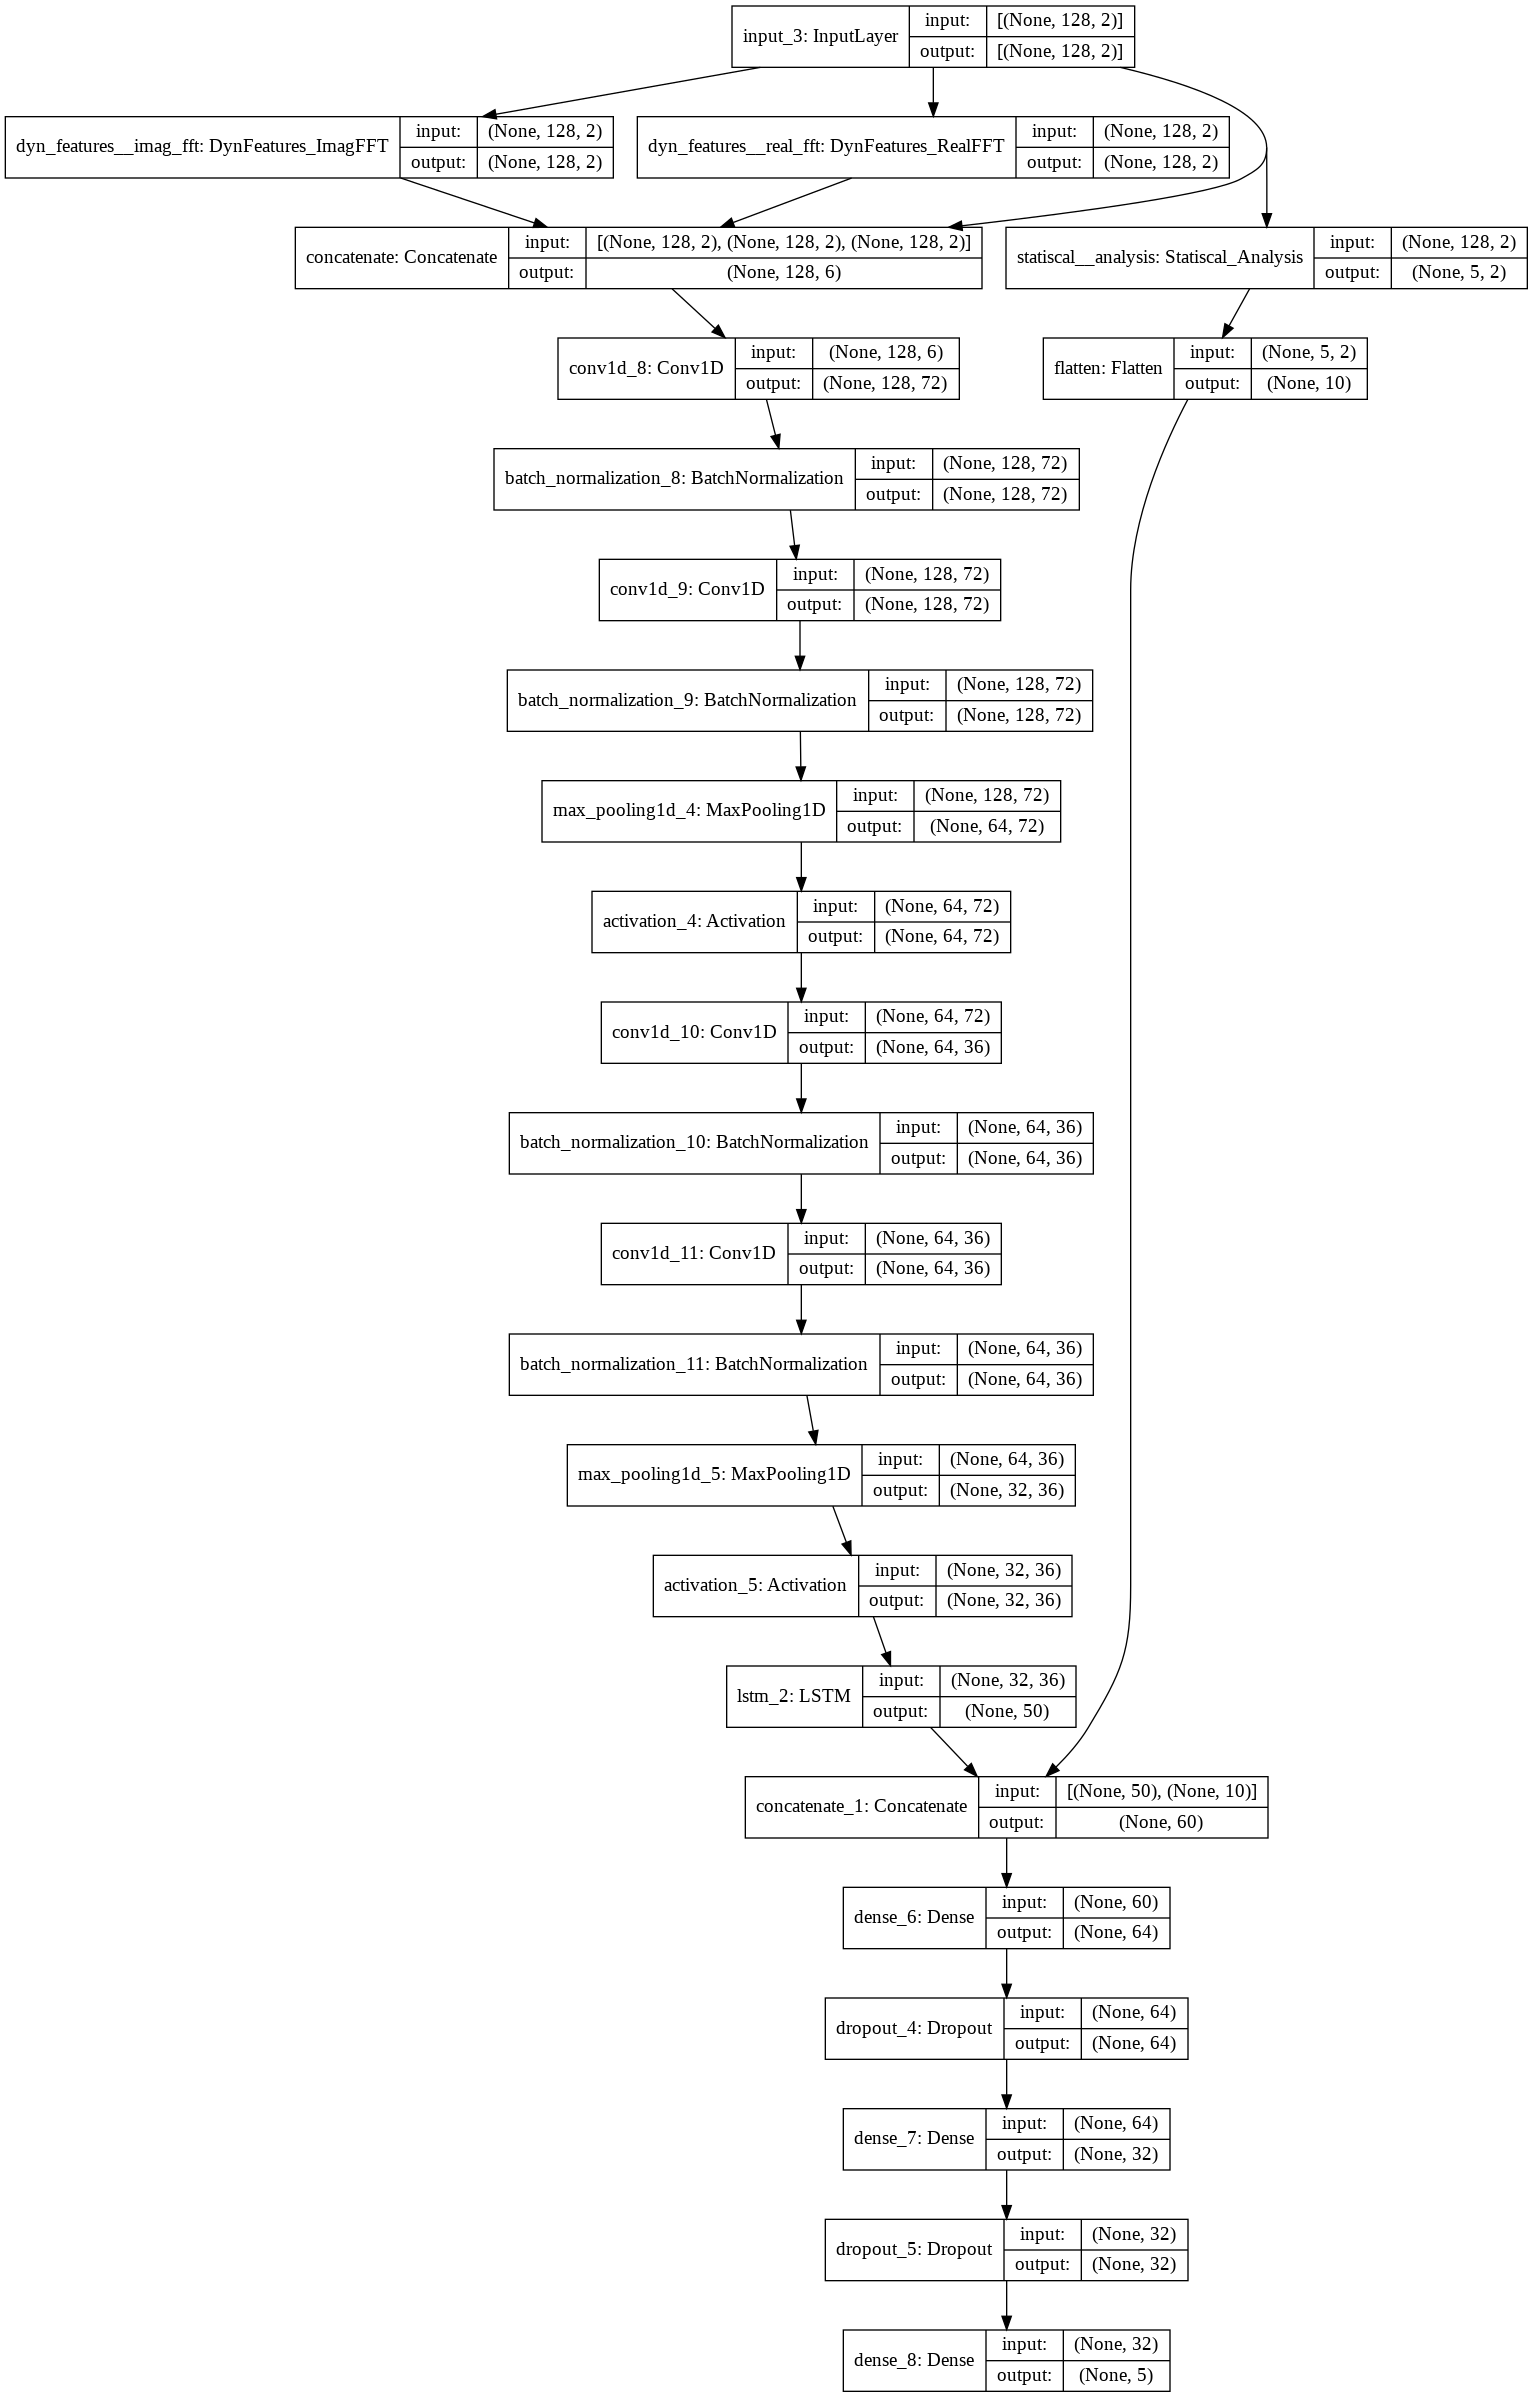

In [23]:
def Convolutional_LSTM_WITHOUT_CWT(kernel = 72, CWT_Freq = 4, kernel_size= 10):
  inputs = keras.Input(shape = (128,2))
  i = DynFeatures_ImagFFT()(inputs)
  r = DynFeatures_RealFFT()(inputs)
  Dynamic_Features = keras.layers.Concatenate()([i,r,inputs])
  Statistical_Features = Statiscal_Analysis(length_of_signal=128)(inputs)
  Statistical_Features = keras.layers.Flatten()(Statistical_Features)
  x = keras.layers.Conv1D(kernel, kernel_size, padding = 'same')(Dynamic_Features)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Conv1D(kernel, kernel_size, padding = 'same')(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.MaxPool1D(pool_size = 2)(x)
  x = keras.layers.Activation('elu')(x)
  x = keras.layers.Conv1D(kernel/2, kernel_size, padding = 'same')(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Conv1D(kernel/2, kernel_size, padding = 'same')(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.MaxPool1D(pool_size = 2)(x)
  x = keras.layers.Activation('elu')(x)
  x = keras.layers.LSTM(50)(x)
  x = keras.layers.Concatenate()([x, Statistical_Features])
  x = keras.layers.Dense(units = 64, activation = 'elu', kernel_initializer = 'he_normal')(x)
  x = keras.layers.Dropout(0.5)(x)
  x = keras.layers.Dense(units = 32, activation = 'elu', kernel_initializer = 'he_normal')(x)
  x = keras.layers.Dropout(0.5)(x)
  outputs = keras.layers.Dense(units = 5, activation = 'softmax')(x)
  model = keras.Model(inputs, outputs)
  return model
CLSTM_WITHOUT_CWT = Convolutional_LSTM_WITHOUT_CWT()
keras.utils.plot_model(CLSTM_WITHOUT_CWT, show_shapes=True)

In [ ]:
CLSTM_WITHOUT_CWT.summary()
CLSTM_WITHOUT_CWT.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

hist2 = CLSTM_WITHOUT_CWT.fit(Train_Dataset, epochs = 10, shuffle = True, validation_data = Valid_Dataset,
                      callbacks = callbacks)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 2)]     0                                            
__________________________________________________________________________________________________
dyn_features__imag_fft (DynFeat (None, 128, 2)       0           input_1[0][0]                    
__________________________________________________________________________________________________
dyn_features__real_fft (DynFeat (None, 128, 2)       0           input_1[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 128, 6)       0           dyn_features__imag_fft[0][0]     
                                                                 dyn_features__real_fft[0][0] 

In [26]:
 from keras.models import Model
 from keras.layers import Input, Dense, LSTM, Bidirectional
 from keras import backend as K

### CLSTM Completed

In [ ]:
from tf_cwt import Wavelet1D

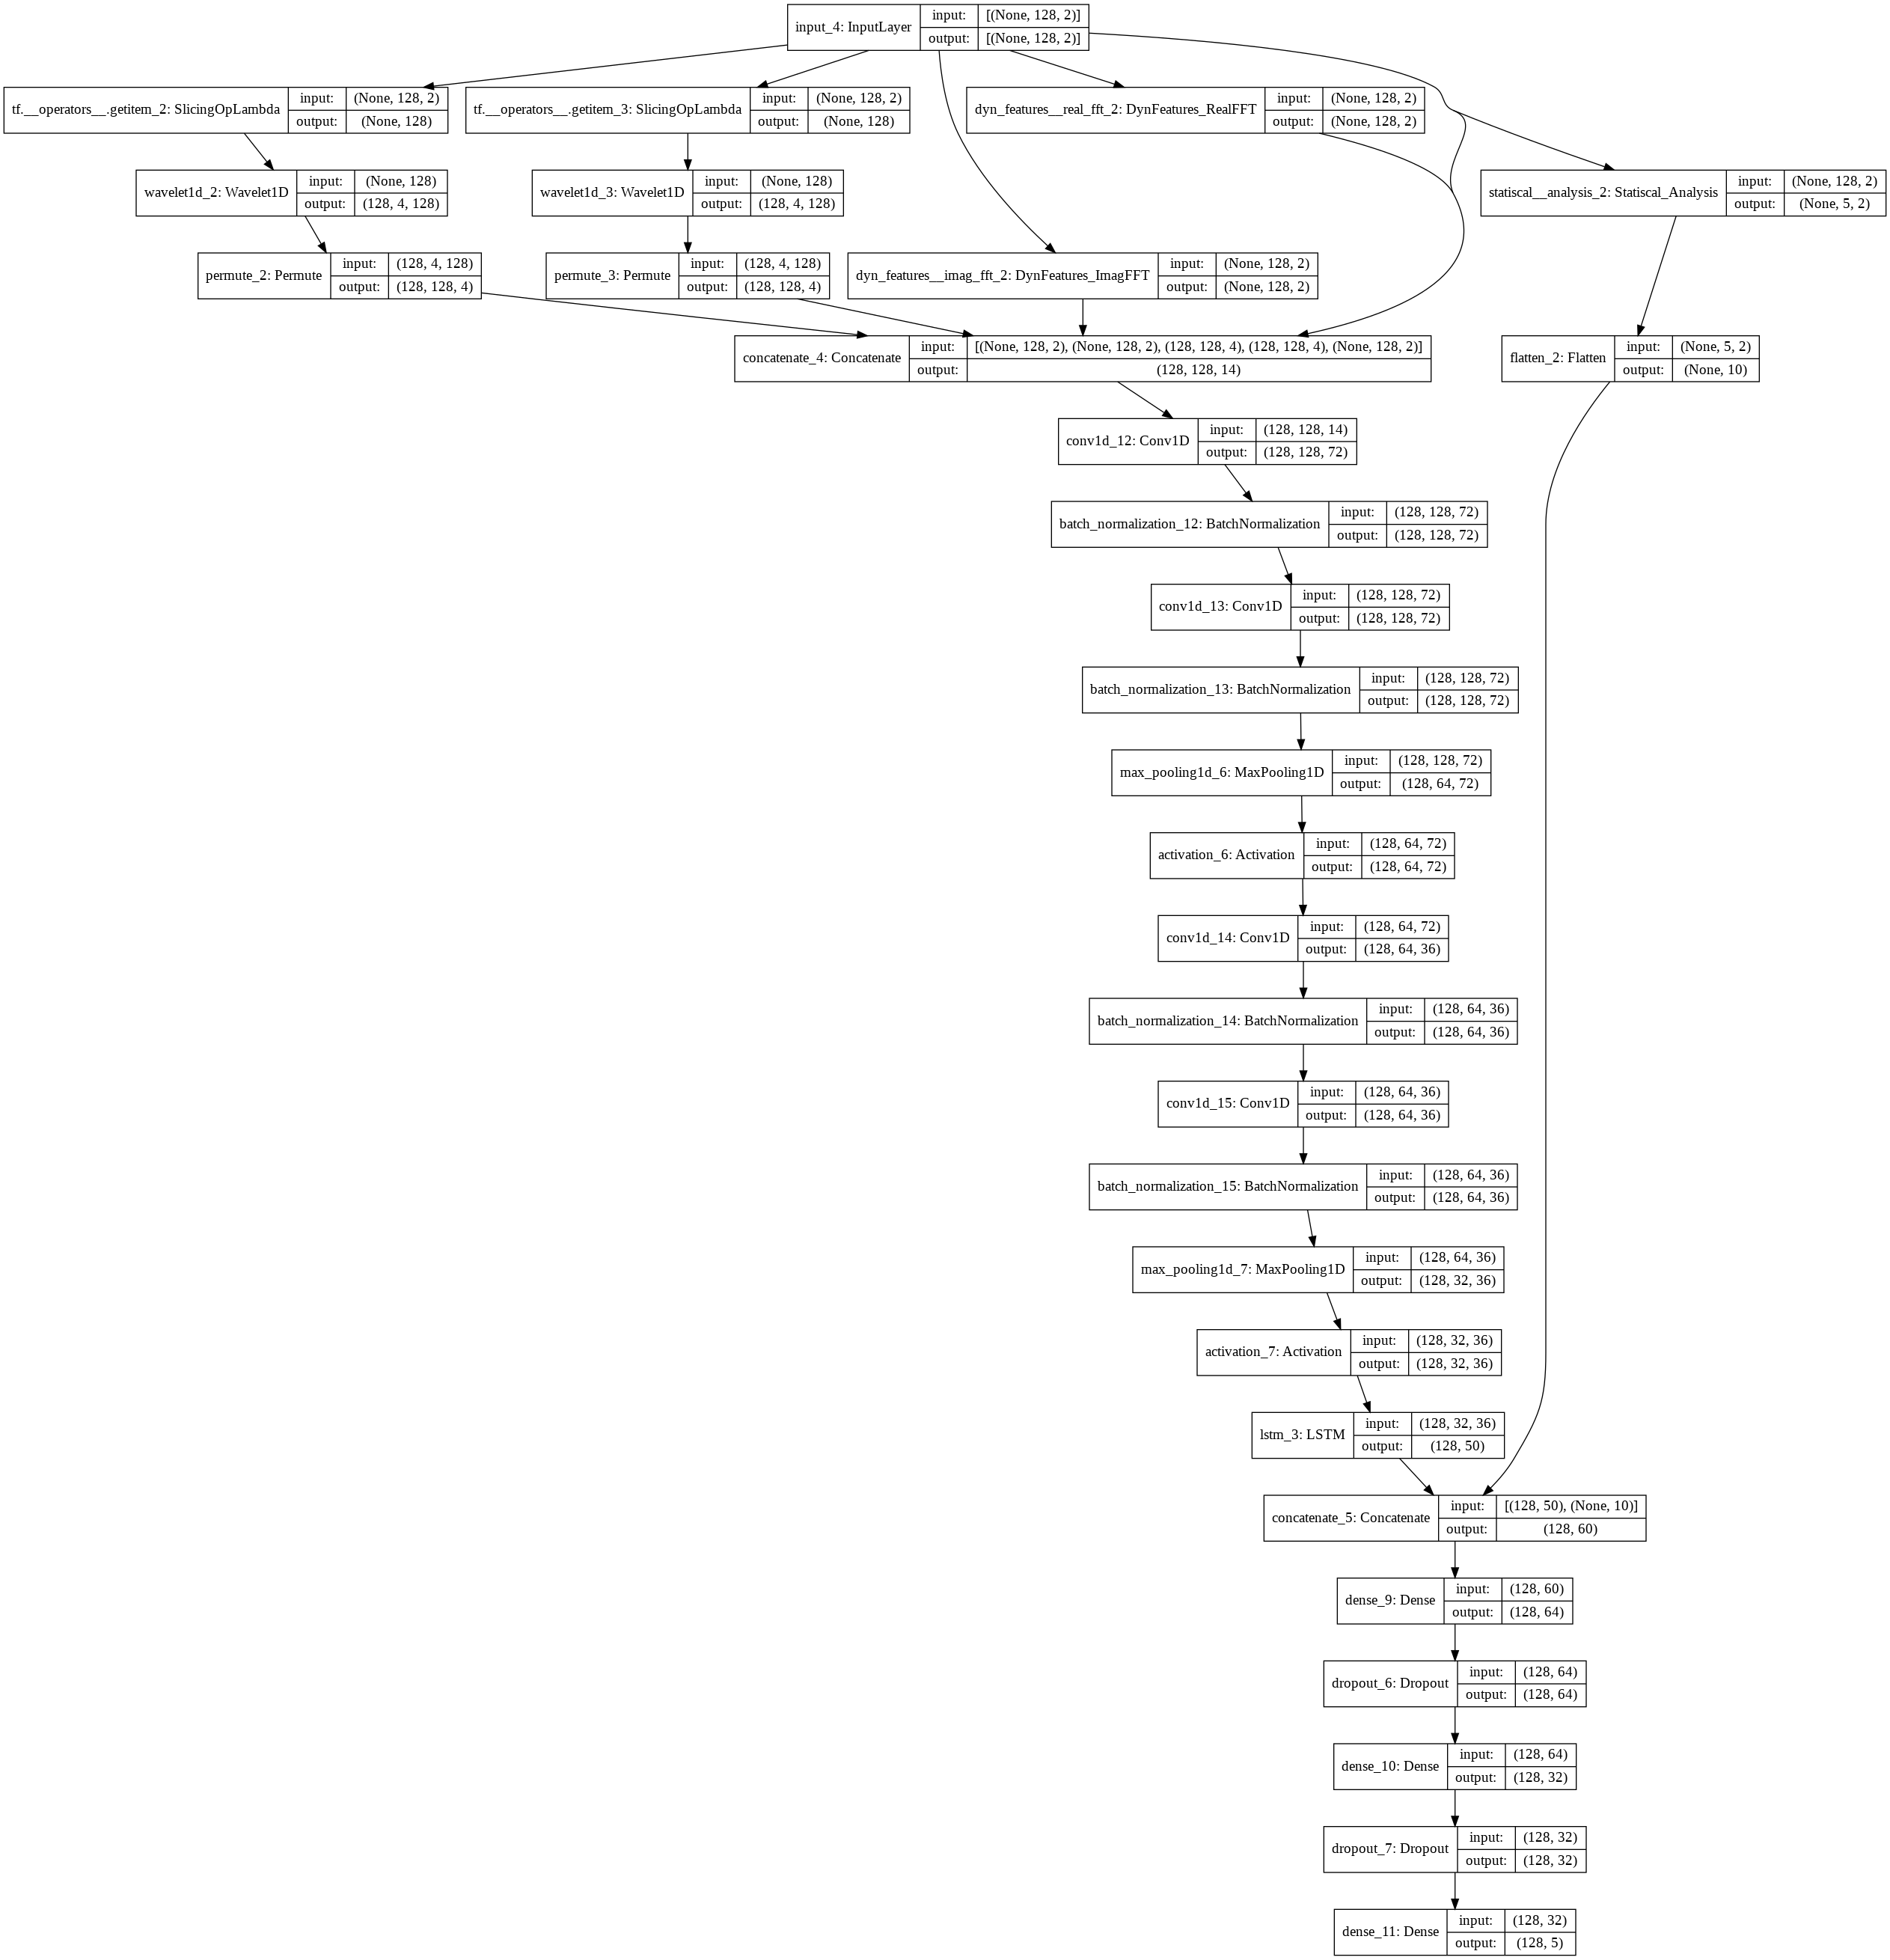

In [ ]:
def Convolutional_LSTM(kernel = 72, CWT_Freq = 4, kernel_size= 5):
  inputs = keras.Input(shape = (128,2))
  i = DynFeatures_ImagFFT()(inputs)
  r = DynFeatures_RealFFT()(inputs)
  c1 = Wavelet1D(batch_size = 128, nv = 12,sr = 1, flow = 0.4, fhigh = 12800)(inputs[:,:,0])
  c1 = keras.layers.Permute((2,1), input_shape=(128,4,128))(c1)
  c2 = Wavelet1D(batch_size = 128, nv = 12,sr = 1, flow = 0.4, fhigh = 12800)(inputs[:,:,1])
  c2 = keras.layers.Permute((2,1), input_shape=(128,4,128))(c2)
  Dynamic_Features = keras.layers.Concatenate()([i,r,c1,c2,inputs])
  Statistical_Features = Statiscal_Analysis(length_of_signal=128)(inputs)
  Statistical_Features = keras.layers.Flatten()(Statistical_Features)
  x = keras.layers.Conv1D(kernel, kernel_size, padding = 'same')(Dynamic_Features)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Conv1D(kernel, kernel_size, padding = 'same')(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.MaxPool1D(pool_size = 2)(x)
  x = keras.layers.Activation('elu')(x)
  x = keras.layers.Conv1D(kernel/2, kernel_size, padding = 'same')(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Conv1D(kernel/2, kernel_size, padding = 'same')(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.MaxPool1D(pool_size = 2)(x)
  x = keras.layers.Activation('elu')(x)
  x = keras.layers.LSTM(50)(x)
  x = keras.layers.Concatenate()([x, Statistical_Features])
  x = keras.layers.Dense(units = 64, activation = 'elu', kernel_initializer = 'he_normal')(x)
  x = keras.layers.Dropout(0.5)(x)
  x = keras.layers.Dense(units = 32, activation = 'elu', kernel_initializer = 'he_normal')(x)
  x = keras.layers.Dropout(0.5)(x)
  outputs = keras.layers.Dense(units = 5, activation = 'softmax')(x)
  model = keras.Model(inputs, outputs)
  return model
CLSTM = Convolutional_LSTM()
keras.utils.plot_model(CLSTM, show_shapes=True)

In [ ]:
CLSTM.summary()
CLSTM.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

hist3 = CLSTM.fit(Train_Dataset, epochs = 10, shuffle = True, validation_data = Valid_Dataset, callbacks = callbacks)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 128, 2)]     0                                            
__________________________________________________________________________________________________
tf.__operators__.getitem_2 (Sli (None, 128)          0           input_4[0][0]                    
__________________________________________________________________________________________________
tf.__operators__.getitem_3 (Sli (None, 128)          0           input_4[0][0]                    
__________________________________________________________________________________________________
wavelet1d_2 (Wavelet1D)         (128, 4, 128)        1024        tf.__operators__.getitem_2[0][0] 
____________________________________________________________________________________________

NameError: ignored

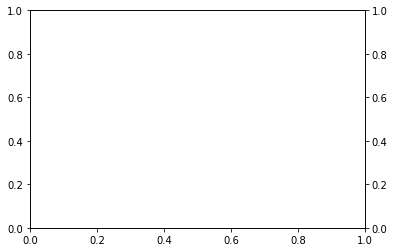

In [ ]:
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()
hist = hist1
loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='rigth')

acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='left')

plt.show()

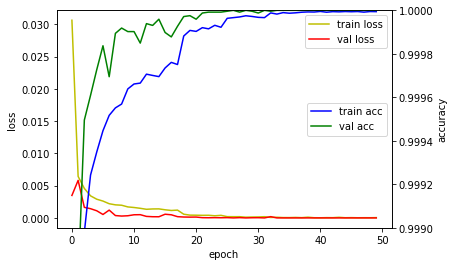

In [ ]:
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()
hist = hist1
loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='center rigth')

acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='right')
plt.ylim([0.999,1])
plt.show()

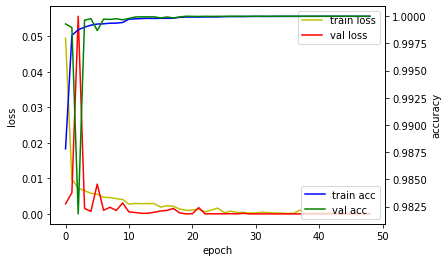

In [ ]:
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()
hist = hist2
loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='rigth')

acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='left')

plt.show()

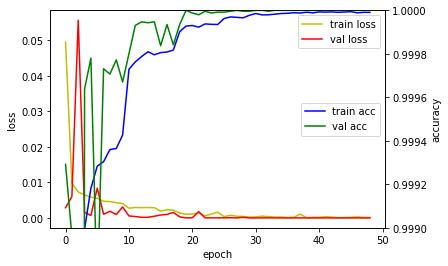

In [ ]:
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()
hist = hist2
loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='center rigth')

acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='right')
plt.ylim([0.999,1])

plt.show()

In [ ]:
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()
hist = hist3
loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='center rigth')

acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='right')

plt.show()

In [ ]:
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()
hist = hist3
loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='center rigth')

acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='right')
plt.ylim([0.999,1])

plt.show()

In [ ]:
fig, loss_ax = plt.subplots()
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

acc_ax = loss_ax.twinx()
acc_ax.plot(hist1.history['val_acc'], 'g', label='val acc 1')
acc_ax.plot(hist2.history['val_acc'], 'r', label='val acc 2')
acc_ax.plot(hist3.history['val_acc'], 'b', label='val acc 3')
plt.show()

In [ ]:
test_Dataset = test_Dataset.batch(128)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f491441b5d0>]],
      dtype=object)

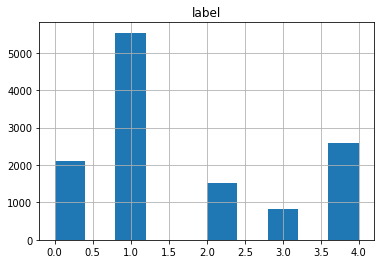

In [ ]:
pred = model35.predict(test_Dataset)
a =np.argmax(pred,axis = 1)
sub.iloc[:,1] = a
sub.to_csv('/content/drive/MyDrive/phm_Result/original.csv', index = False)
sub.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f49145de710>]],
      dtype=object)

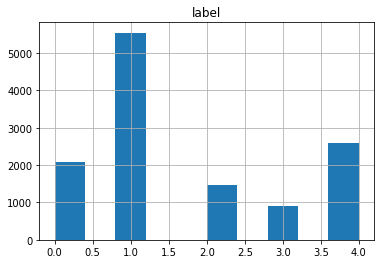

In [ ]:
pred=CLSTM_WITHOUT_CWT.predict(test_Dataset)
a =np.argmax(pred,axis = 1)
sub.iloc[:,1] = a
sub.to_csv('/content/drive/MyDrive/phm_Result/model_CLSTM_WITHOUT_CWT.csv', index = False)
sub.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4913fc9e90>]],
      dtype=object)

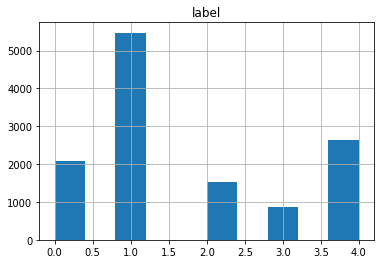

In [ ]:
pred=CLSTM_WITHOUT_CWT_LAYER.predict(test_Dataset)
a =np.argmax(pred,axis = 1)
sub.iloc[:,1] = a
sub.to_csv('/content/drive/MyDrive/phm_Result/model_CLSTM_WITHOUT_CWT_layer.csv', index = False)
sub.hist()

In [ ]:
pred=CLSTM.predict(test_Dataset)
a =np.argmax(pred,axis = 1)
sub.iloc[:,1] = a
sub.to_csv('/content/drive/MyDrive/model_CLSTM.csv', index = False)
sub.hist()